<a href="https://colab.research.google.com/github/FrancisDiesto/CarbonEmmissionPerCapita/blob/main/CNN_Monkeypox.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install tensorflow tensorflow-gpu opencv-python matplotlib

In [ ]:
#!pip list

In [ ]:
import tensorflow as tf
import os

In [ ]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
tf.config.list_physical_devices('GPU')

[]

remove dodgy images


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls ./content/gdrive

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
ls: cannot access './content/gdrive': No such file or directory


In [ ]:
import cv2
import imghdr
from matplotlib import pyplot as plt

In [ ]:
data_dir = 'data' 

In [ ]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [ ]:
os.chdir('/content/gdrive/MyDrive/')

In [ ]:
!pwd


/content/gdrive/MyDrive


In [ ]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

test if you can see pic

In [ ]:
img= cv2.imread(os.path.join('data', 'Monkeypox','M01_01_00.jpg'))

In [ ]:
img.shape

(224, 224, 3)

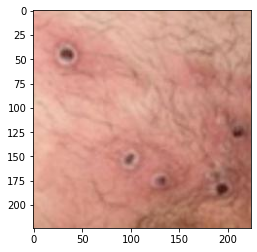

In [ ]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

Load Data

In [ ]:
import numpy as np

In [ ]:
# image resize 
im_height = 80
im_width = 80
im_size = 80

In [ ]:
data = tf.keras.utils.image_dataset_from_directory(
    'data', 
    image_size =(im_height,im_width))

Found 2142 files belonging to 2 classes.


In [ ]:
data_iterator = data.as_numpy_iterator()

In [ ]:
# get a different sample batch each run
batch = data_iterator.next()

In [ ]:
batch[0].shape

(32, 80, 80, 3)

In [ ]:
#class 1 = Others
#class 0 = Monkeypox

batch[1]

array([0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 1, 0, 1, 1, 1, 1, 1, 0, 0], dtype=int32)

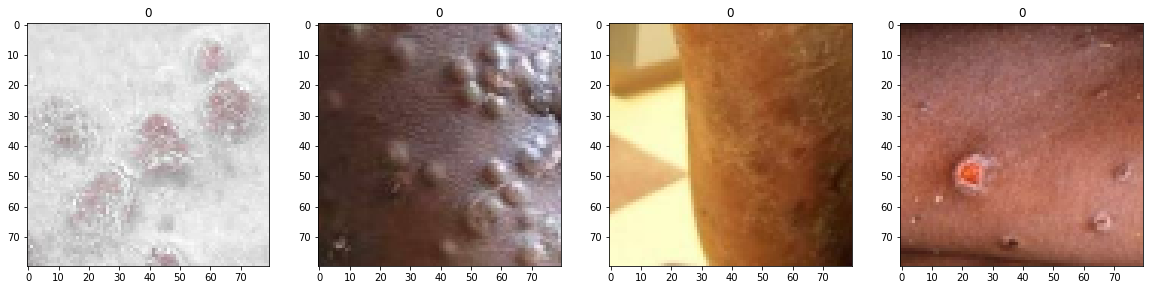

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [ ]:
data = data.map(lambda x,y: (x/im_size, y))

In [ ]:
scaled_iterator = data.as_numpy_iterator()

In [ ]:
batch = scaled_iterator.next()

In [ ]:
batch[0].max()
batch[0].min()

0.0

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

In [ ]:
len(data)

67

In [ ]:
print(67*.70)
print(67*.10)
print(67*.20)

46.9
6.7
13.4


In [ ]:
#split our data 
#train_size and test_size +1 to fit the length of data

train_size = int(len(data)*.70)
val_size = int(len(data)*.20)
test_size = int(len(data)*.10)

In [ ]:
#see if total size is equal to data length
train_size +val_size +test_size

65

In [ ]:
#how many batches 

train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [ ]:
len(test)

6

Build the model 

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization

In [ ]:
model = Sequential()

In [ ]:
# 4 convolution layer
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(im_height,im_width,3)))   # input layer, convolution has 16 filters which extracts relevent features of an image
model.add(MaxPooling2D())                                                                # filter is 3 by 3 pixels in size and a stride 1, stride means movement                                                                             # relu activation = output that is not zero is converted to zero, positive values are preserved

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.3))                                                     # max value out of 2 by 2 region which halves and condenses information

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.3))  
                                     
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.2)) 

# 1 flatten layer
model.add(Flatten())                                                          


# 2 Dense layers
model.add(Dense(256, activation='relu'))                                      # fully connected layer
model.add(Dense(1, activation='sigmoid'))                                     # single output since we are using our sigmoide function 
                                                                              # 0 if our function is 


In [ ]:
#adam is our optimizer
#loss is a binary classification
#metric that we want to track is accuracy
model.compile('adam', loss = tf.losses.BinaryFocalCrossentropy(), metrics = ['accuracy'])

In [ ]:
model.summary()
# our first convolution layer turns our input from 256, 256, 3 into 254, 254, 16
# our max pooling layer converts the new output to 127, 127, 16 which is the half of our previous output (not a trainable layer)

#flatten layer (30*30*16 = 14400) condenses output from multidimension to 
# 257 because weights from neurons and bias term

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 78, 78, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 39, 39, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 37, 37, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 18, 18, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 18, 18, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 32)        9

Train

In [ ]:
logdir = 'logs'

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logdir)

In [ ]:
# we use hist to plot out our training data
# ideally what you want to see is your loss go down and the accuracy going up as you pass through epochs
hist = model.fit(train, epochs = 50, validation_data = val, callbacks=[tensorboard_callback])

Epoch 1/50
46/46 [==============================] - 14s 273ms/step - loss: 0.1743 - accuracy: 0.5618 - val_loss: 0.1692 - val_accuracy: 0.6082
Epoch 2/50
46/46 [==============================] - 12s 243ms/step - loss: 0.1664 - accuracy: 0.6094 - val_loss: 0.1635 - val_accuracy: 0.6250
Epoch 3/50
46/46 [==============================] - 11s 235ms/step - loss: 0.1599 - accuracy: 0.6406 - val_loss: 0.1651 - val_accuracy: 0.6058
Epoch 4/50
46/46 [==============================] - 11s 238ms/step - loss: 0.1616 - accuracy: 0.6359 - val_loss: 0.1600 - val_accuracy: 0.6538
Epoch 5/50
46/46 [==============================] - 12s 265ms/step - loss: 0.1620 - accuracy: 0.6501 - val_loss: 0.1587 - val_accuracy: 0.6587
Epoch 6/50
46/46 [==============================] - 13s 267ms/step - loss: 0.1566 - accuracy: 0.6562 - val_loss: 0.1501 - val_accuracy: 0.7019
Epoch 7/50
46/46 [==============================] - 13s 266ms/step - loss: 0.1544 - accuracy: 0.6644 - val_loss: 0.1566 - val_accuracy: 0.6707

Plot our performance

In [ ]:
hist.history

{'loss': [0.17428597807884216,
  0.1664019525051117,
  0.1599218249320984,
  0.1615503579378128,
  0.16204345226287842,
  0.1565828174352646,
  0.15440748631954193,
  0.1516941338777542,
  0.14747099578380585,
  0.14429831504821777,
  0.15558961033821106,
  0.1437348574399948,
  0.14879004657268524,
  0.14074978232383728,
  0.13841116428375244,
  0.13277842104434967,
  0.12917008996009827,
  0.12453032284975052,
  0.11768404394388199,
  0.11915601789951324,
  0.1194349154829979,
  0.10881837457418442,
  0.10427016764879227,
  0.10274063050746918,
  0.10212302953004837,
  0.10051967948675156,
  0.0961981788277626,
  0.08423204720020294,
  0.08300058543682098,
  0.08964186906814575,
  0.07544860988855362,
  0.09416155517101288,
  0.0834883376955986,
  0.07963352650403976,
  0.0708106979727745,
  0.07021857053041458,
  0.07464001327753067,
  0.06808734685182571,
  0.06113787740468979,
  0.06232929229736328,
  0.06397964805364609,
  0.06000368669629097,
  0.06290934979915619,
  0.066006243

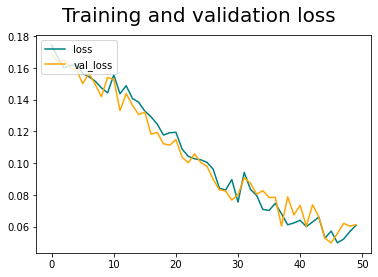

In [ ]:
#loss and val_loss visualization

fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Training and validation loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

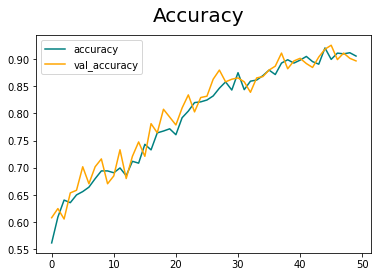

In [ ]:
#accuracy visulaization

fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

Evaluate Performance

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [ ]:
len(test)

6

In [ ]:
# loop trough all testing batches
for batch in test.as_numpy_iterator(): 
    X, y = batch # y true value
    yhat = model.predict(X) # make prediction returns 0 or 1 because of sigmoid function
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 52ms/step


In [ ]:
y_pred = model.predict(X)
y_pred = np.round_(y_pred)

print(confusion_matrix(y, y_pred))

1/1 [==============================] - 0s 58ms/step
[[16  2]
 [ 0 14]]


In [ ]:
print(yhat)

[[0.43807983]
 [0.5825924 ]
 [0.72657627]
 [0.277794  ]
 [0.61886096]
 [0.8392383 ]
 [0.4816213 ]
 [0.1799117 ]
 [0.03486385]
 [0.18336211]
 [0.9070485 ]
 [0.5530098 ]
 [0.00592394]
 [0.38233325]
 [0.05360648]
 [0.6564946 ]
 [0.0342376 ]
 [0.46407303]
 [0.9675245 ]
 [0.84846747]
 [0.40426683]
 [0.9964431 ]
 [0.5152875 ]
 [0.64904815]
 [0.94015753]
 [0.00778065]
 [0.74794036]
 [0.03295174]
 [0.44988972]
 [0.6870202 ]
 [0.03733576]
 [0.8253895 ]]


In [ ]:
print(f'Precision:{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')
print()

Precision:0.8524590134620667, Recall:0.9629629850387573, Accuracy:0.8854166865348816



Testing outside of batch

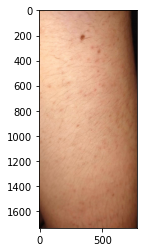

In [ ]:
img = cv2.imread('others_test.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

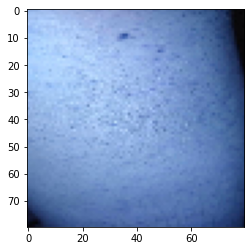

In [ ]:
resize = tf.image.resize(img,(im_height, im_width))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [ ]:
np.expand_dims(resize, 0).shape

(1, 80, 80, 3)

In [ ]:
yhat = model.predict(np.expand_dims(resize/im_size, 0))

1/1 [==============================] - 0s 75ms/step


In [ ]:
yhat

array([[0.6471797]], dtype=float32)

In [ ]:
#with binary classification 
if yhat > 0.5:
  print(f'Predicted class is Others')
else:
  print(f'Predicted class is Monkeypox')

Predicted class is Others


Save the model

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
model.save(os.path.join('models', 'Monkeypox_Classifier_Model.h5'))

In [ ]:
new_model = load_model(os.path.join('models', 'Monkeypox_Classifier_Model.h5'))

Use saved new_model again

In [ ]:
yhatnew =  new_model.predict(np.expand_dims(resize/80,0))

1/1 [==============================] - 0s 73ms/step


In [ ]:
#with binary classification 
if yhat > 0.5:
  print(f'Predicted class is Others')
else:
  print(f'Predicted class is Monkeypox')

Predicted class is Others
